This is a step by step guide for the reproduction of the experiments found in the paper of Aldene & Provost.

Cite:
Z. Aldeneh and E. M. Provost, "You're Not You When You're Angry: Robust Emotion Features Emerge by Recognizing Speakers" in IEEE Transactions on Affective Computing, vol. 14, no. 02, pp. 1351-1362, April-June 2023, doi: 10.1109/TAFFC.2021.3086050.

#Libraries to install

In [ ]:
pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.2/807.2 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 27.7 MB/s eta 0:00:00


In [ ]:
!pip install umap-learn
import umap.umap_ as umap

#Libraries to import

In [7]:
import os
import zipfile
import pickle
import tarfile
import shutil
from zipfile import ZipFile
import librosa
from IPython.display import Audio
import speechbrain
from speechbrain.inference.speaker import EncoderClassifier
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
import umap.umap_ as umap

import torch
import torchaudio

from torch.nn import Sequential, Linear
from torch.nn import Sigmoid, Tanh, ReLU, LeakyReLU, Bilinear, MSELoss
import torch.nn.functional as F

from torch.optim import Adam

from torch.utils.data import DataLoader

#Get dataset Librispeech

In [1]:
!kaggle datasets download -d marianarodrguez/emotionaudio-librispeech

Dataset URL: https://www.kaggle.com/datasets/marianarodrguez/emotionaudio-librispeech
License(s): unknown
100% 10.3G/10.3G [07:36<00:00, 28.7MB/s]
100% 10.3G/10.3G [07:36<00:00, 24.3MB/s]


In [4]:
with zipfile.ZipFile('/content/emotionaudio-librispeech.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/')

#X-VECTORS OF LIBRISPEECH

In [ ]:
def Data_to_Index(file, columns, subsest_position, columns_to_drop=['']):
  df = pd.read_csv(file, delimiter='\t')
  rows = []
  for i in range(len(df)):
    rows.append(df.iloc[i][0].split('|'))
  df = pd.DataFrame(rows, columns=columns)
  my_dataset = []
  for i in range(len(rows)):
      row = [i.strip() for i in df.iloc[i]]
      if row[subsest_position] == 'train-clean-100' or row[subsest_position] == 'dev-clean':
        my_dataset.append(row)
  my_dataset = pd.DataFrame(my_dataset, columns=columns)
  my_dataset.drop(columns=columns_to_drop, inplace=True)
  return my_dataset

In [ ]:
filePATH = '/content/train-clean-100/speakers.TXT'
columns = ['ID_SPEAKER', 'SEX', 'SUBSET', 'MINUTES', 'NAME']
subsest_position = 2
columns_to_drop = ['MINUTES','SUBSET']
speaker_data = Data_to_Index(filePATH, columns, subsest_position, columns_to_drop)

In [ ]:
filePATH = '/content/train-clean-100/chapters.TXT'
columns = ['ID_CHAPTER','ID_SPEAKER','MINUTES', 'SUBSET', 'PROJ', 'ID_BOOK', 'CH TITLE', 'PROJ TITLE']
subsest_position = 3
columns_to_drop = ['MINUTES','SUBSET','PROJ']
chapter_data = Data_to_Index(filePATH, columns, subsest_position, columns_to_drop)

In [ ]:
def to_index(data):
  indexNo_chapter = chapter_data[chapter_data['ID_SPEAKER'] == data].index
  indexNo_speaker = speaker_data[speaker_data['ID_SPEAKER'] == data].index
  return indexNo_chapter[0], indexNo_speaker[0]

>Dataset X-Vectors

In [ ]:
def Obtain_x_vectors(folder_path):
  y_speaker = []
  path = folder_path
  classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")
  dataset_x_vector = []
  for folder in sorted(os.listdir(path)):
    speakerIndex = to_index(folder)
    for folder2 in os.listdir(path + '/' + folder):
      for folder3 in os.listdir(path + '/' + folder + '/' + folder2):
        if folder3[-5:] == '.flac':
          y_speaker.append(speakerIndex)
          signal, fs = torchaudio.load(path + '/' + folder + '/' + folder2 + '/' + folder3)
          x_vector = classifier.encode_batch(signal).reshape([512])
          dataset_x_vector.append(x_vector)

  return dataset_x_vector, y_speaker


In [ ]:
Valid_Xvectors, y_val = Obtain_x_vectors('/content/dev-clean/dev-clean')
Train_Xvectors, y_train = Obtain_x_vectors('/content/train-clean-100/train-clean-100')

> (Section not on the paper) Testing x-vectors with umap for its analysis

In [ ]:
dicc_sexo = {'M':0,'F':1}
dicc_persona = {c: i for i, c in enumerate(speaker_data['NAME'])}
dicc_nombre_capitulo = {c: i for i, c in enumerate(chapter_data['CH TITLE'])}

In [ ]:
persona = []
sexo = []
nombre_capitulo = []

for y in y_Train:
  persona.append(dicc_persona[speaker_data['NAME'][y[1]]])
  sexo.append(dicc_sexo[speaker_data['SEX'][y[1]]])
  nombre_capitulo.append(dicc_nombre_capitulo[chapter_data['CH TITLE'][y[0]]])

In [ ]:
y_persona = y_Train[:,1]
label_persona = list(dicc_persona.keys())

y_sexo = sexo
label_sexo = list(dicc_sexo.keys())

y_nombre_capitulo = nombre_capitulo
label_nombre_capitulo = list(dicc_nombre_capitulo.keys())

In [ ]:
plotdata = []
pca = PCA(n_components=2)
pca_plot = pca.fit(Train_Xvectors)
plot = pca.transform(Train_Xvectors)

In [ ]:
def plot2d(x,y,labels):
  plt.figure(figsize=(5,5))
  sc = plt.scatter(x[:,0],x[:,1],c=y)
  plt.rcParams['font.family'] = 'sans-serif'
  plt.legend(handles=sc.legend_elements()[0], labels=labels)
  plt.show

In [ ]:
print(Train_Xvectors.shape)
len(label_nombre_capitulo)

In [ ]:
plot2d(Train_Xvectors,y_persona,label_persona)

In [ ]:
plot2d(Train_Xvectors,y_sexo,label_sexo)

In [ ]:
plot2d(Train_Xvectors,y_nombre_capitulo,label_nombre_capitulo)

In [ ]:
x_umap2_StadisticsGlottal_CreamD = umap.UMAP(n_neighbors=100,n_components=2,min_dist=0.1,metric='euclidean').fit_transform(Train_Xvectors,y_sexo)
plot2d(x_umap2_StadisticsGlottal_CreamD,y_sexo,label_sexo)

In [ ]:
x_umap2_StadisticsGlottal_CreamD = umap.UMAP(n_neighbors=100,n_components=2,min_dist=0.1,metric='euclidean').fit_transform(Train_Xvectors,y_nombre_capitulo)
plot2d(x_umap2_StadisticsGlottal_CreamD,y_nombre_capitulo,label_nombre_capitulo)

In [ ]:
x_umap2_StadisticsGlottal_CreamD = umap.UMAP(n_neighbors=100,n_components=2,min_dist=0.1,metric='euclidean').fit_transform(Train_Xvectors,y_persona)
plot2d(x_umap2_StadisticsGlottal_CreamD,y_persona,label_persona)

#GPU

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()

#PRE-TRAINING WITH LIBRISPEECH

In [ ]:
qt = QuantileTransformer(n_quantiles=10, random_state=0)
qt_train = qt.fit_transform(np.array(Train_Xvectors))
qt_valid = qt.transform(np.array(Valid_Xvectors))

In [ ]:
qt_train = 2 * (qt_train - 0.5)
qt_valid = 2 * (qt_valid - 0.5)

In [ ]:
qt_valid.shape

In [ ]:
Batch_size = 256

In [ ]:
train_dl = DataLoader(qt_train, batch_size=Batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(qt_valid, batch_size=Batch_size, shuffle=False, num_workers=3, pin_memory=True)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#Model

In [ ]:
class Base(torch.nn.Module):
    def training_step(self, batch):
        out = self(batch)
        loss = F.mse_loss(out, batch)
        return loss, out

    def validation_step(self, batch):
        out = self(batch)
        loss = F.mse_loss(out, batch, reduction='none')
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))
        #print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

In [ ]:
class Modelo(Base):
  def __init__(self):
    super(Modelo, self).__init__()

    self.cod = Sequential(Linear(512, 256),
                          Tanh(),
                          Linear(256, 128),
                          Tanh(),
                          Linear(128, 64),
                          Tanh(),
                          Linear(64, 32),
                          Tanh(),
                          Linear(32, 16))
    self.dec = Sequential(Linear(16, 32),
                          Tanh(),
                          Linear(32, 64),
                          Tanh(),
                          Linear(64, 128),
                          Tanh(),
                          Linear(128, 256),
                          Tanh(),
                          Linear(256, 512))

  def forward(self, x):
    z = self.cod(x)
    x = self.dec(z)

    return x

In [ ]:
model_ac = to_device(Modelo(), device)

#Trainning code

In [ ]:
def evaluate(model_ac, val_loader):
    model_ac.eval()
    outputs = [model_ac.validation_step(batch) for batch in val_loader]
    return model_ac.validation_epoch_end(outputs)

def evaluation(model_ac, val_loader):
    model_ac.eval()
    outputs = [model_ac.validation_step(batch) for batch in val_loader]
    return [x.mean() for x in outputs[0]['val_loss']]

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def try_model(epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    early_stop = [0,0,0,0,0]

    optimizer = opt_func(model.parameters(), lr, weight_decay = weight_decay)
    prev_val_loss = 1
    saved = 1
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()

        train_losses = []
        input_vector = []
        output_vector = []
        lrs = []

        for batch in train_loader:
            optimizer.zero_grad()

            loss, out = model.training_step(batch)
            train_losses.append(loss)

            loss.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()

        early_stop.insert(epoch % 5, round(result['val_loss'], 4))
        early_stop.pop(epoch % 5 + 1)
        if epoch == 0:
          model.epoch_end(epoch, result)
        history.append(result)
        if np.mean(early_stop) == round(result['val_loss'],4):
          break
    return history

In [ ]:
epochs = 100
max_lr = 1e-3
grad_clip = 1e-4
weight_decay = 1e-4
opt_func = torch.optim.Adam

#Trainning phase

In [ ]:
history = [evaluate(model_ac, train_dl)]
history

In [ ]:
history += try_model(epochs, max_lr, model_ac, train_dl, valid_dl, weight_decay, grad_clip, opt_func=opt_func)

In [ ]:
#We first pre-train the autoencoders using neutral speech from the LibriSpeech corpus
torch.save(model_ac.state_dict(), '/content/librispeech_pre_training.pth')

In [ ]:
def plot_loss(history):
    validation = [x['val_loss'] for x in history[1:]]
    train = [x['train_loss'] for x in history[1:]]
    plt.plot(validation, '-x')
    plt.plot(train, '-o')
    plt.xlabel('epoch')
    plt.ylabel('train loss orange, valid loss blue')
    plt.title('validation vs. No. of epochs');

In [ ]:
plot_loss(history)

#Load weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
weights = torch.load('/content/librispeech_pre_training.pth', map_location=torch.device('cpu'))

<ipython-input-24-2b8c205a9b80>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('/content/drive/MyDrive/LibriSpeech/librispeech_pre_training.pth', map_

#VESUS - Test 1

##Xvectors

We run two separate analyses
whenever we use the VESUS dataset: one using the intended
(i.e., instructed) emotion labels, and another using utterances
that achieved at least 50% consistency among the crowd-
sourced annotators (i.e., at least five annotators agreed).

In [ ]:
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")
signal, _ = torchaudio.load('/content/drive/MyDrive/MuSe/Instru/1002174.mp3')
signal = signal[:48000]
x_vector = classifier.encode_batch(signal)
x_vector.shape

torch.Size([2, 1, 512])

In [ ]:
def Xvectors(path):
  classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")
  folder_audio = '/content/VESUS/VESUS' + path
  signal, _ = torchaudio.load(folder_audio)
  x_vector = classifier.encode_batch(signal).reshape([512])
  return x_vector.numpy()

In [ ]:
csv_file_path = '/content/drive/MyDrive/VESUS/VESUS_Key.csv'
df = pd.read_csv(csv_file_path)

In [ ]:
emotion_dict = {'Neutral':0,'Angry':1,'Happy':2,'Sad':3,'Fearful':4}

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
dict_percived = {str(i): {emotion: [] for emotion in emotions} for i in range(1, 11)}

emotion_dict = {'Neutral':'0','Angry':'1','Happy':'2','Sad':'3','Fearful':'4'}

for row in range(len(df)):
  actor = df.iloc[row]['Actor Number']
  emotion = df.iloc[row]['Instructed Emotion']
  if emotion in ['Neutral', 'Happy', 'Sad', 'Angry']:
    perceived = df.iloc[row]['Perceived Emotion 0:Neu,Ang,Hap,Sad,4:Fea']
    rate = perceived.count(emotion_dict[emotion])
    if rate >= 5:
      dict_percived[str(actor)][emotion].append(df.iloc[row]['File Path'])

In [ ]:
emotions = ['Neutral', 'Angry', 'Sad', 'Happy']
dataset_types = ['train', 'test']

dataset_test_1_intended = {str(i): {emotion: {dtype: [] for dtype in dataset_types}for emotion in emotions} for i in range(1, 11)}
dataset_test_1_perceived = {str(i): {emotion: {dtype: [] for dtype in dataset_types}for emotion in emotions} for i in range(1, 11)}

In [ ]:
def ends(actor, emotion):
  path = '/content/VESUS/VESUS/' + str(actor) + '/' + emotion
  lenght = len(os.listdir(path))
  end = int(lenght * 0.7)
  end_p = int(len(dict_percived[str(actor)][emotion])*0.7)
  return end, end_p

In [ ]:
emotions = ['Neutral', 'Angry', 'Sad', 'Happy']
emotion_dict = {'Neutral':'0','Angry':'1','Happy':'2','Sad':'3','Fearful':'4'}

for row in range(len(df)):
  emotion = df.iloc[row]['Instructed Emotion']
  if emotion in emotions:
    actor_n = df.iloc[row]['Actor Number']
    perceived = df.iloc[row]['Perceived Emotion 0:Neu,Ang,Hap,Sad,4:Fea']
    path = df.iloc[row]['File Path']

    end_train, end_train_p = ends(actor_n, emotion)
    part = "train"
    lenght = len(dataset_test_1_intended[str(actor_n)][emotion][part])
    if lenght == end_train:
      part = 'test'
    x = Xvectors(path)
    dataset_test_1_intended[str(actor_n)][emotion][part].append(x)

    rate = perceived.count(emotion_dict[emotion])
    if rate >= 5:
      part = "train"
      lenght = len(dataset_test_1_perceived[str(actor_n)][emotion][part])
      if lenght == end_train_p:
        part = 'test'
      dataset_test_1_perceived[str(actor_n)][emotion][part].append(x)

In [ ]:
with open('/content/dataset_test1_perceived_Actors.pickle', 'wb') as f:
    pickle.dump(dataset_test_1_perceived, f)

with open('/content/dataset_test1_intended_Actors.pickle', 'wb') as f:
    pickle.dump(dataset_test_1_intended, f)

##Reconstruction Error

In [ ]:
dataset_test1_intended_history = {'1':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '2':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '3':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '4':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '5':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '6':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '7':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '8':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '9':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                 '10':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []}}

In [ ]:
dataset_test1_perceived_history = {'1':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '2':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '3':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '4':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '5':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '6':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '7':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '8':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                   '9':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []},
                                  '10':{'Neutral': [], 'Angry': [], 'Sad': [], 'Happy': []}}

In [ ]:
with open('/content/dataset_test1_intended_Actors.pickle', 'rb') as f:
  test1_Intended = pickle.load(f)
with open('/content/dataset_test1_perceived_Actors.pickle', 'rb') as f:
  test1_Perceived = pickle.load(f)

In [ ]:
def normalization(dataset, actor_n, emotion):
    qt = QuantileTransformer(n_quantiles=10, random_state=0)
    lenght = len(dataset[actor_n][emotion]['test'])
    if  lenght == 75:
      dataset[actor_n][emotion]['test'].append(dataset[actor_n][emotion]['train'][0])
    qt_train = qt.fit_transform(np.array(dataset[actor_n][emotion]['train']))
    qt_valid = qt.transform(np.array(dataset[actor_n][emotion]['test']))
    qt_train = 2 * (qt_train - 0.5)
    qt_valid = 2 * (qt_valid - 0.5)
    return qt_train, qt_valid

def dataloader_Norm(qt_train, qt_valid):
    Batch_size = 256
    train_dl = DataLoader(qt_train, batch_size=Batch_size, shuffle=True, num_workers=2, pin_memory=True)
    valid_dl = DataLoader(qt_valid, batch_size=Batch_size, shuffle=False, num_workers=2, pin_memory=True)
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)
    return train_dl, valid_dl

In [ ]:
emotions = ['Happy','Sad', 'Angry']

for actor_n in range(1,11):
  model_ac.load_state_dict(weights)
  qt_train, qt_valid = normalization(test1_Intended,str(actor_n),'Neutral')
  train_dl, valid_dl = dataloader_Norm(qt_train, qt_valid)
  history = [evaluate(model_ac, train_dl)]
  history += try_model(epochs, max_lr, model_ac, train_dl, valid_dl, weight_decay, grad_clip, opt_func=opt_func)
  eval = evaluation(model_ac, valid_dl)
  dataset_test1_intended_history[str(actor_n)]['Neutral'].append(eval)

  for emotion in emotions:
    qt_train, qt_valid = normalization(test1_Intended,str(actor_n),emotion)
    train_dl, valid_dl = dataloader_Norm(qt_train, qt_valid)
    eval = evaluation(model_ac, valid_dl)
    dataset_test1_intended_history[str(actor_n)][emotion].append(eval)


In [ ]:
emotions = ['Happy', 'Sad', 'Angry']

for actor_n in range(1,11):
  model_ac.load_state_dict(weights)
  qt_train, qt_valid = normalization(test1_Perceived,str(actor_n),'Neutral')
  train_dl, valid_dl = dataloader_Norm(qt_train, qt_valid)
  history = [evaluate(model_ac, train_dl)]
  history += try_model(epochs, max_lr, model_ac, train_dl, valid_dl, weight_decay, grad_clip, opt_func=opt_func)
  eval = evaluation(model_ac, valid_dl)
  dataset_test1_perceived_history[str(actor_n)]['Neutral'].append(eval)

  for emotion in emotions:
    qt_train, qt_valid = normalization(test1_Perceived,str(actor_n),emotion)
    train_dl, valid_dl = dataloader_Norm(qt_train, qt_valid)
    eval = evaluation(model_ac, valid_dl)
    dataset_test1_perceived_history[str(actor_n)][emotion].append(eval)


Epoch [0], train_loss: 0.2249, val_loss: 0.2236
Epoch [0], train_loss: 0.2315, val_loss: 0.2363
Epoch [0], train_loss: 0.2307, val_loss: 0.2231
Epoch [0], train_loss: 0.2374, val_loss: 0.2423
Epoch [0], train_loss: 0.2469, val_loss: 0.2454
Epoch [0], train_loss: 0.2230, val_loss: 0.2287
Epoch [0], train_loss: 0.2156, val_loss: 0.2110
Epoch [0], train_loss: 0.2439, val_loss: 0.2470
Epoch [0], train_loss: 0.2282, val_loss: 0.2345


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (10) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(


Epoch [0], train_loss: 0.2391, val_loss: 0.2426


In [ ]:
with open('/content/dataset_test1_intended_history.pickle', 'wb') as f:
  pickle.dump(dataset_test1_intended_history,f)

In [ ]:
with open('/content/dataset_test1_perceived_history.pickle', 'wb') as f:
  pickle.dump(dataset_test1_perceived_history, f)

##Graficar

In [ ]:
perceived_history = dataset_test1_perceived_history

In [ ]:
with open('/content/dataset_test1_intended_history.pickle', 'rb') as f:
  intended_history = pickle.load(f)
with open('/content/dataset_test1_perceived_history.pickle', 'rb') as f:
  perceived_history = pickle.load(f)

In [9]:
def datasetEmotions(history, genre):
  dictForM = {'Female': [1,6],'Male': [6,11]}
  rangeForM = dictForM[genre]
  emotions = ['Neutral', 'Angry', 'Happy', 'Sad']

  data_per_emotion = []
  data_per_actor = []

  for emotion in emotions:
    for actor_n in range(rangeForM[0],rangeForM[1]):
      for RE in history[str(actor_n)][emotion][0]:
        data_per_actor.append(RE)
    data_per_emotion.append(data_per_actor)
    data_per_actor = []
  return data_per_emotion

In [10]:
def dataframe(data_per_emotion):
  return pd.DataFrame(np.array(data_per_emotion).T)

def dataframe_P(data_per_emotion):
  data_per_emotion1 = pd.DataFrame(np.array(data_per_emotion[0]).T)
  data_per_emotion2 = pd.DataFrame(np.array(data_per_emotion[1]).T)
  data_per_emotion3 = pd.DataFrame(np.array(data_per_emotion[2]).T)
  data_per_emotion4 = pd.DataFrame(np.array(data_per_emotion[3]).T)
  return pd.concat([data_per_emotion1, data_per_emotion2, data_per_emotion3, data_per_emotion4], axis=1)

In [11]:
intended_Female = datasetEmotions(intended_history, 'Female')
intended_Male = datasetEmotions(intended_history, 'Male')
perceived_Female = datasetEmotions(perceived_history, 'Female')
perceived_Male = datasetEmotions(perceived_history, 'Male')

In [12]:
intended_Female = dataframe(intended_Female)
intended_Male = dataframe(intended_Male)
perceived_Female = dataframe_P(perceived_Female)
perceived_Male = dataframe_P(perceived_Male)

In [13]:
perceived_Female.columns = ['Neutral', 'Angry', 'Happy', 'Sad']
perceived_Male.columns = ['Neutral', 'Angry', 'Happy', 'Sad']

In [14]:
columns = ['Neutral', 'Angry', 'Happy', 'Sad']

In [16]:
def plot_box(plotboxes, genre, figu):
    # Check if plotboxes is a DataFrame and has the correct structure
    if not isinstance(plotboxes, pd.DataFrame):
        raise ValueError("The input plotboxes must be a pandas DataFrame.")
    if plotboxes.shape[1] < 4:
        raise ValueError("The DataFrame must have at least 4 columns.")

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(18, 9))

    # Create a boxplot for each column of the DataFrame
    bp = ax.boxplot(
        [plotboxes[col].dropna().values for col in plotboxes.columns],  # Drop NaN values
        patch_artist=True,
        widths=0.6
    )

    # Adjust the thickness of the axes
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    # Adjust the thickness of the grid
    ax.grid(True, linewidth=2)

    # Increase the thickness of the elements of the boxplot
    for element in ['boxes', 'whiskers', 'caps', 'medians']:
        for line in bp[element]:
            line.set_linewidth(2)

    # Set the x-ticks to correspond to the number of columns in the DataFrame
    ax.set_xticks(np.arange(1, len(plotboxes.columns) + 1))
    ax.set_xticklabels(plotboxes.columns, fontsize=25)

    # Set labels and title
    plt.ylabel('Reconstruction Error', fontsize=30)
    plt.title(genre, fontsize=30)
    plt.yticks(np.arange(0.05, 0.41, 0.1))

    # Save the figure
    plt.savefig(f'{figu}.png', format='png', bbox_inches='tight')

    # Show the plot
    plt.show()


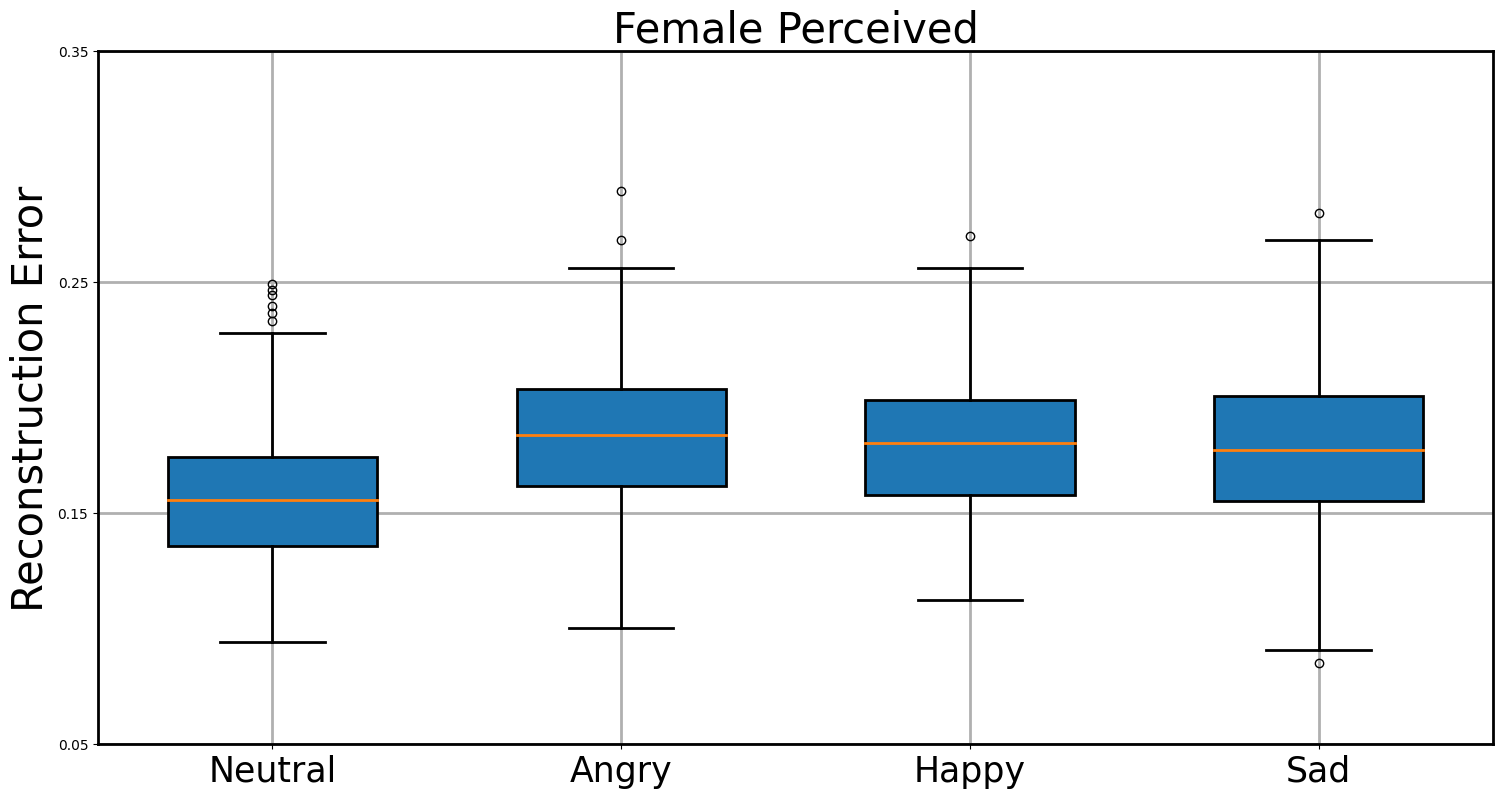

In [17]:
plot_box(perceived_Female, 'Female Perceived','FemalePerceived')

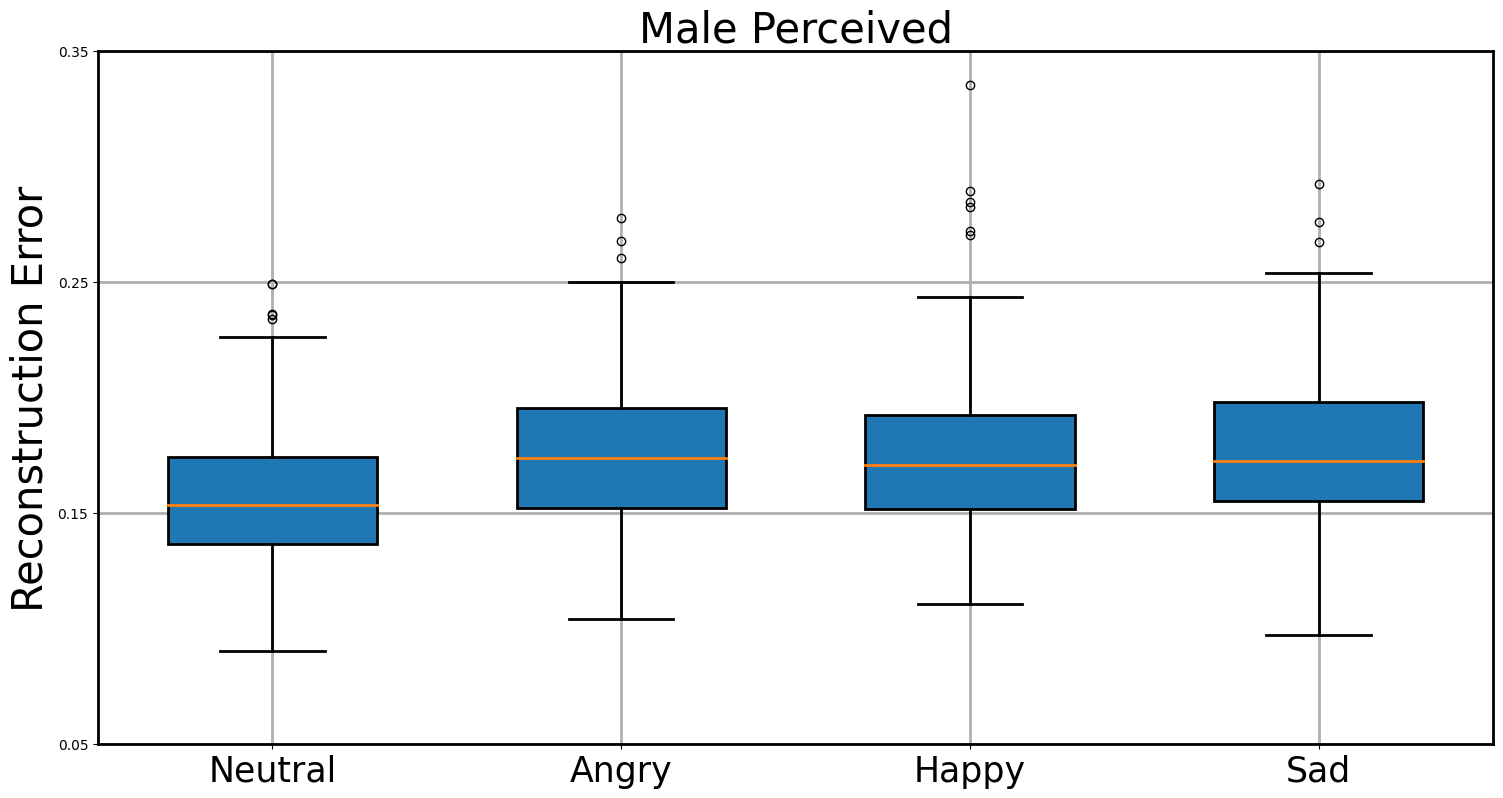

In [18]:
plot_box(perceived_Male, 'Male Perceived', 'Malepercived')

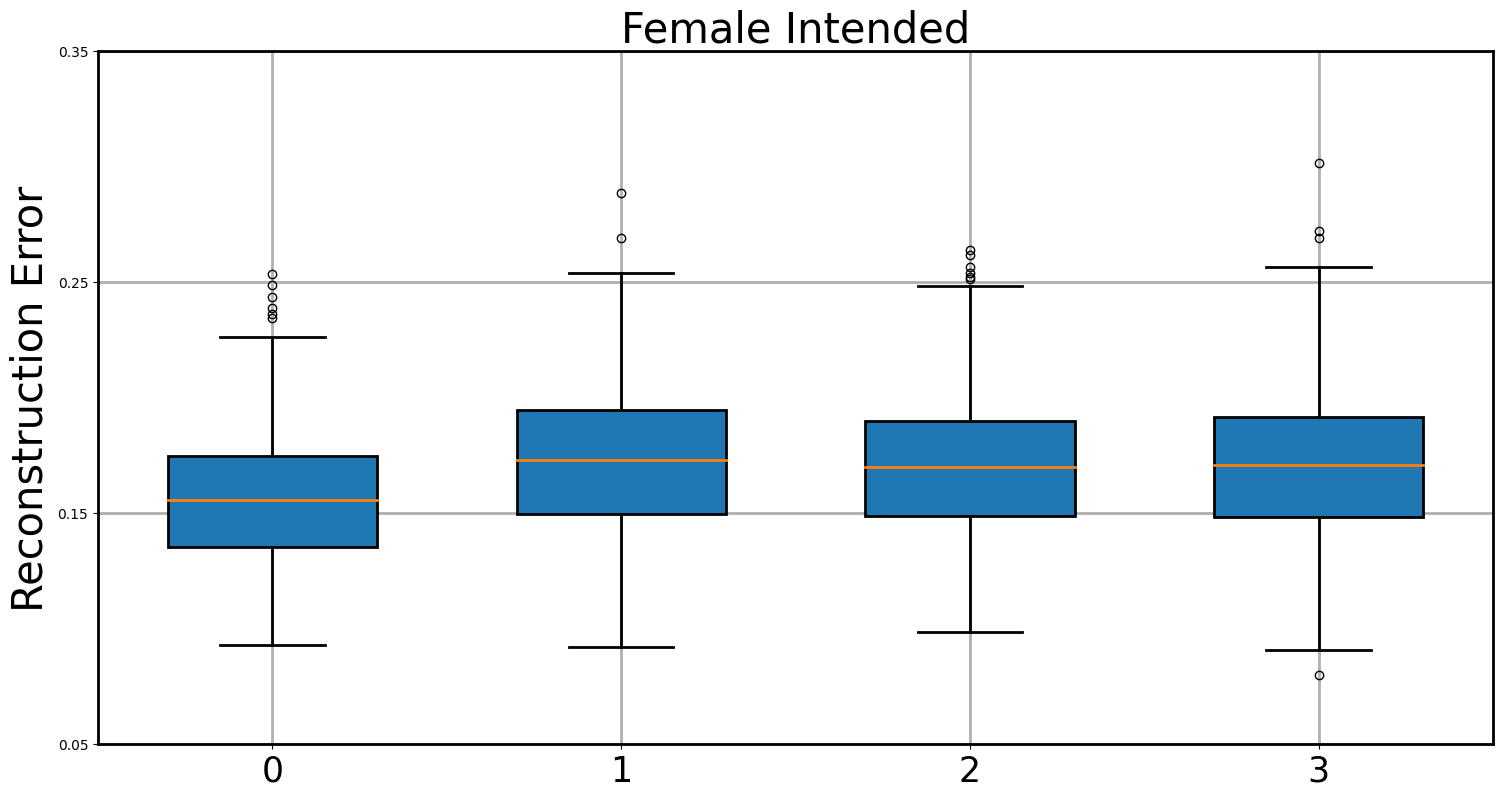

In [20]:
plot_box(intended_Female, 'Female Intended', 'femaleperceived')

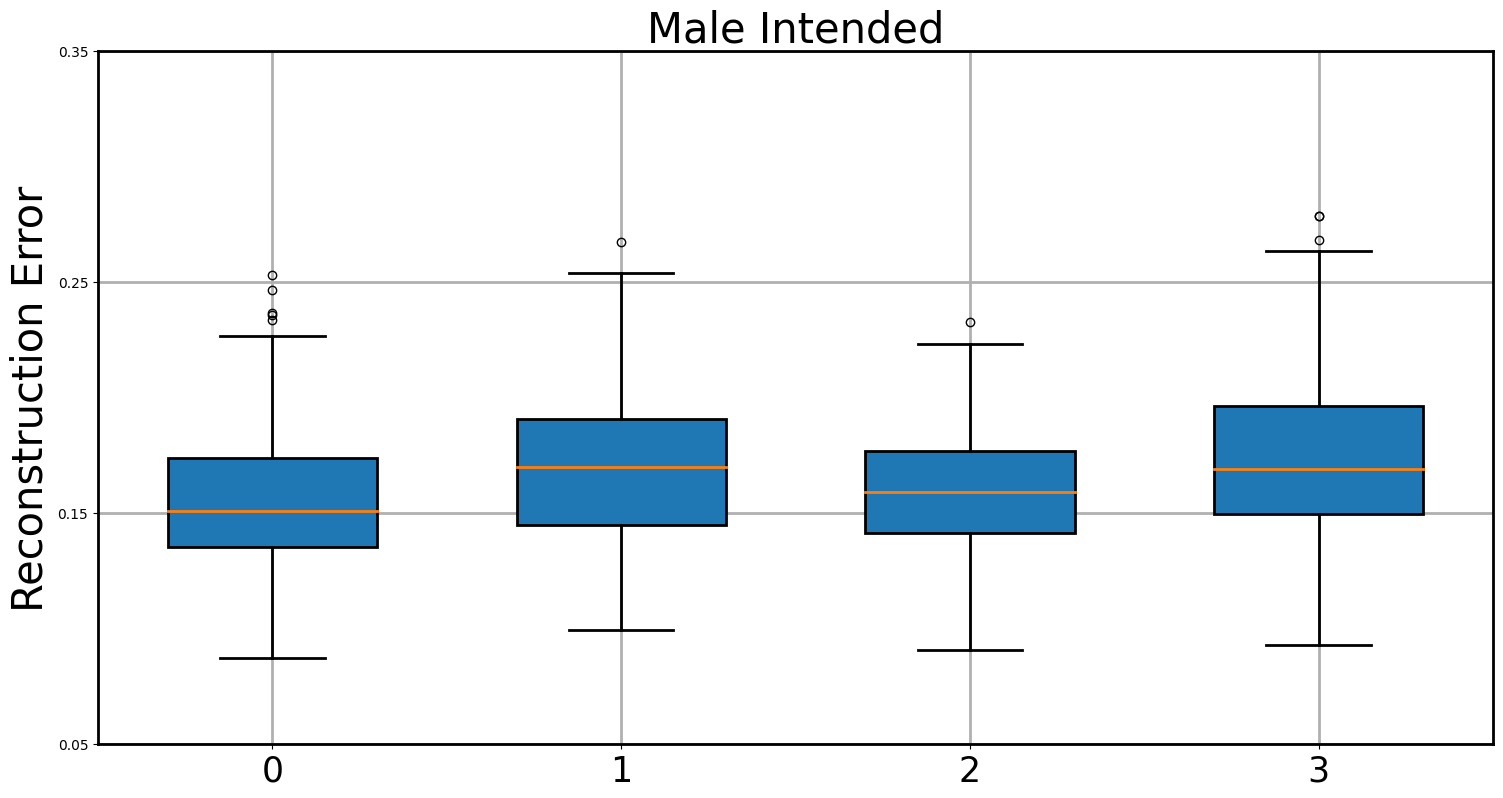

In [22]:
plot_box(intended_Male, 'Male Intended', 'maleIntended')